## Stock data

Baseado no estudo de [Curtis Miller](https://ntguardian.wordpress.com) sobre a análise de dados do mercado de valores.

* [Black–Scholes model](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model)
* [The mathematical equation that caused the banks to crash](https://www.theguardian.com/science/2012/feb/12/black-scholes-equation-credit-crunch)

## Obtendo e visualizando dados de estoque

O primeiro ponto é obter os dados de estoque. Para isso vamos utilizar os dados disponíveis em dois sites referências e com dados abertos: **Yahoo Finance** e **Google Finance**. Vamos criar um **DataFrame** com os dados obtidos.

In [5]:
#http://blog.yhat.com/posts/stock-data-python.html
import pandas as pd
import pandas_datareader as web
import datetime

# Define o range de data a ser pesquisada
start = datetime.datetime(2016,1,1)
#end = datetime.date.today()
end = datetime.datetime(2016,12,31)

# Vamos obter os dados do estoque da Apple; O ticker da Apple é AAPL
# No método de extração de dados, o primeiro argumento é a série que queremos buscar, 
#o segundo argumento é a fonte, neste caso "yahoo" para o Yahoo! Finance, 
#o terceiro e quarto parametros são a data de início e data final da pesquisa
apple = web.DataReader("AAPL", "yahoo", start, end)

type(apple)

apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,102.610001,105.370003,102.000000,105.349998,101.790649,67649400
2016-01-05,105.750000,105.849998,102.410004,102.709999,99.239845,55791000
2016-01-06,100.559998,102.370003,99.870003,100.699997,97.297760,68457400
2016-01-07,98.680000,100.129997,96.430000,96.449997,93.191338,81094400
2016-01-08,98.550003,99.110001,96.760002,96.959999,93.684120,70798000


Analisando o resultado, vemos que **Open** é o preço da ação no início do dia de negociação (vale notar que este valor não precisa ser o preço de fechamento do pregão anterior). **High** é o preço mais alto que o **estoque** alcançou no dia de negociação. **Low** é o menor preço que as ações alcançaram no dia de negociação. **Close** é o valor do preço do **estoque** na hora do encerramento das negociações. Pulando uma coluna temos o **Volume** que indica quantos `estoques` foram negociados no dia. A coluna **Adj Close** ou **Fechamento ajustado** é o preço do fechamento do `estoque` que ajusta o preço do mesmo para as ações coorporativas. Este é o preço de fechamento em qualquer dia de negociação que foi alterado para incluir quaisquer distribuições e ações corporativas que ocorreram em qualquer momento antes da abertura do dia seguinte. O preço de fechamento ajustado é freqüentemente usado ao examinar retornos históricos ou realizar uma análise detalhada sobre estes retornos históricos.

* http://www.investopedia.com/terms/a/adjusted_closing_price.asp
* https://vantagepointtrading.com/trading-glossary/trading-glossary-a/adjusted-closing-price-definition-and-uses/


## Visualizando dados de estoque

Agora que temos os dados de estoque vamos trabalhar na visualização. 

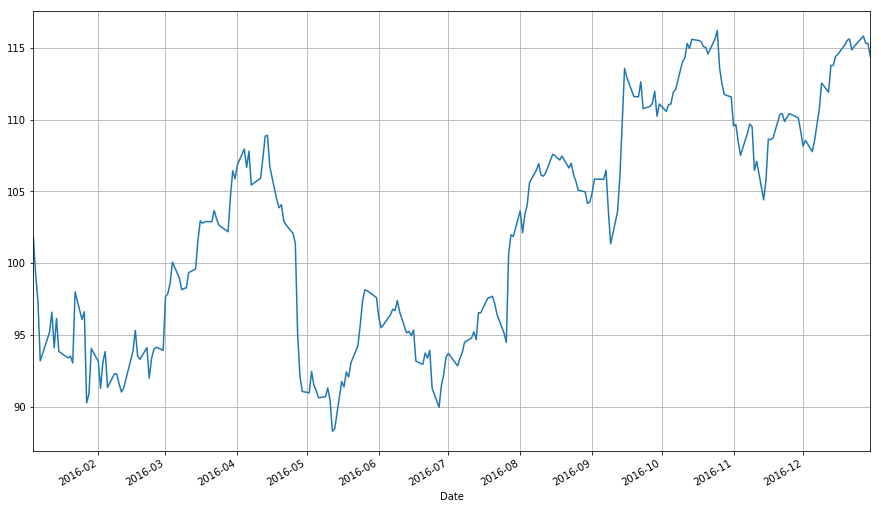

In [6]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (15, 9)   # Definindo o tamanho do plot

# Exibir o "adjusted closing price" para as ações de estoque da AAPL
apple["Adj Close"].plot(grid = True)

O resultado do código acima será um `linechart` baseado no campo **Adj Close**. Para uma visualização significativa, temos que considerar pelo menos quatro variáveis, **Open**, **High**, **Low** e **Close**.


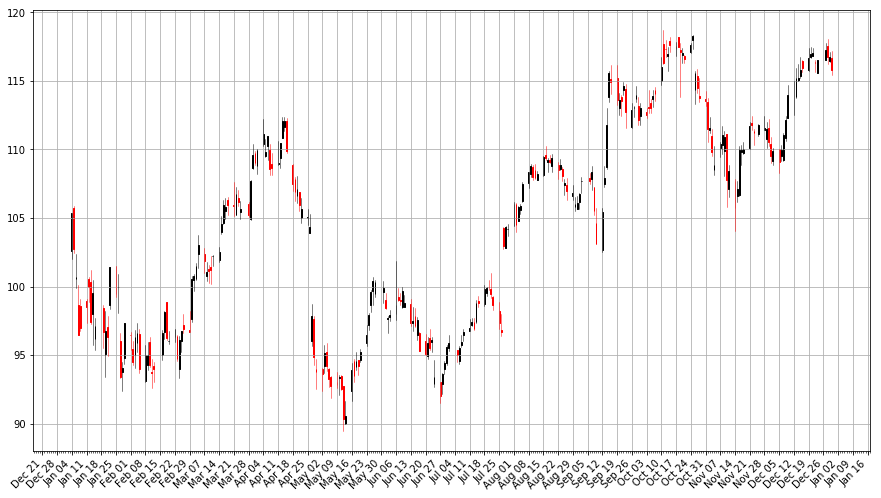

In [7]:
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc

def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines

    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12

    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365

    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))

    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')


    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)

    ax.grid(True)

    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)

    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)

    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.show()

pandas_candlestick_ohlc(apple)